# EDA+DTM
by Anny Liu

This document contains data cleanning & wrangling, exploarary data analysis 
(token count and frequency trend), and dynamtic topic modeling (using LDA model) part.

Help source: <br/>
External resources were referenced in the coding part of the stopword list and the DTM model.
Detailed information can be found in reference.md. Chatgpt helped in debugging some part of the code.

In [8]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import nltk
import wordcloud
import gensim
import pyLDAvis

In [9]:
from TCSP import read_stopwords_list

In [10]:
from gensim.models import ldaseqmodel
from gensim.corpora import Dictionary, bleicorpus
from gensim.matutils import hellinger

In [11]:
# for chinese character display
#!pip install -U mplfonts
from mplfonts.bin.cli import init
init()

c:\Users\Annii\anaconda3\Lib\site-packages\fontTools\misc\py23.py:11: DeprecationWarning: The py23 module has been deprecated and will be removed in a future release. Please update your code.
  warnings.warn(
c:\Users\Annii\anaconda3\Lib\site-packages\fire\core.py:59: DeprecationWarning: 'pipes' is deprecated and slated for removal in Python 3.13
  import pipes


In [12]:
from mplfonts import use_font
use_font('Noto Sans CJK SC')

### Keyword - Topic reference table

| 民主与公义 (Democracy and Justice) | 抗议与抗争 (Protest and Resistance) | 政府与治理 (Government and Governance) |
|------------------------------------|--------------------------------------|----------------------------------------|
| 民主 (Democracy)                   | 示威者 (Protesters)                  | 政府 (Government)                      |
| **公义 (Justice)**                     | 示威 (Protest)                       | 特首 (Chief Executive)                 |
| 公平 (Fairness)                    | **抗争 (Resistance)**                    | 黑社会 (Triads)                        |
| 投票 (Voting)                    | 文宣 (Propaganda)                    | 滲透 (Infiltration)                    |
| 利益 (Interest)                    | 打壓 (Suppression)                   | 極權 (Authoritarianism)                |
| 保衛 (Defense)                     | **对抗 (Confrontation)**                 |                                        |
| 普選 (General Election)            | 落街 (Hit the Streets)               |

## Data Cleaning/Wrangling
read json file

In [13]:
def read_json(filepath):
    """
    Read json file into pandas dataframe

    Input: filepath

    Output: df
    """
    df = pd.DataFrame(columns=['time', 'support', 'against', 'post_id', 'year', 'month', 'keywords', 'cleaned_text']) 
    #Notes for grader:
    #when reading file GovtoAuthon and proRest, change the 'keywords' column 
    #to 'keyword' to avoid error
    #GovtoAuthon and proRest: keyword; other file: keywords

    with open(filepath, 'r', encoding='UTF-8') as file:

        for line in file:
            data = json.loads(line)
            
            df = pd.concat([df, pd.DataFrame([data], columns=df.columns)], ignore_index=True)
    
    return df

In [14]:
#Democracy and Justice
democracy = read_json(r'..\clean data\Democracy_cleaned.json')
fairness = read_json(r'..\clean data\Fairness_cleaned.json')
voting = read_json(r'..\clean data\voting_cleaned.json')
interest = read_json(r'..\clean data\Interest_cleaned.json')
defense = read_json(r'..\clean data\Defense_cleaned.json')
general_election = read_json(r'..\clean data\General Election_cleaned.json')

In [15]:
DJ = pd.concat([democracy, fairness, voting, interest, defense, \
                general_election], ignore_index=True)

In [16]:
#Protest and Resistance
HitStreet = read_json(r'..\clean data\HitStreet_cleaned.json')
Propaganda = read_json(r'..\clean data\Propaganda_cleaned.json')
Suppression = read_json(r'..\clean data\Suppression_cleaned.json')

In [17]:
proRest = read_json(r'..\clean data\proRest_cleaned.json')
proRest = proRest.rename(columns={'keyword': 'keywords'})

C:\Users\Annii\AppData\Local\Temp\ipykernel_19496\2179588545.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([data], columns=df.columns)], ignore_index=True)


In [18]:
# test df for subkeywords
# Protest = proRest[proRest['keywords'] == '示威']
# Protesters = proRest[proRest['keywords'] == '示威者']

In [19]:
PR = pd.concat([HitStreet, Propaganda, Suppression, proRest], ignore_index=True)

In [20]:
#Government and Governance
Authoritarianism = read_json(r'..\clean data\Authoritarianism_cleaned.json')
Infiltration = read_json(r'..\clean data\Infiltration (1)_cleaned.json')

In [21]:
GovtoAuthon = read_json(r'..\clean data\GovtoAuthon_cleaned.json')
GovtoAuthon = GovtoAuthon.rename(columns={'keyword': 'keywords'})

In [22]:
# test df for subkeywords
# Triads = GovtoAuthon[GovtoAuthon['keywords'] == '黑社会']
# Chief_Executive = GovtoAuthon[GovtoAuthon['keywords'] == '特首']
# Government = GovtoAuthon[GovtoAuthon['keywords'] == '政府']

In [23]:
GG = pd.concat([Authoritarianism, Infiltration, GovtoAuthon], ignore_index=True)

In [24]:
# keyword error when scraping; do some replacement; will not effect the final results
# replacement_dict = {'政府': 'Government', '特首': 'Chief_Executive', '黑社会':'Triads', '極權':'Authoritarianism'}
# GG['keywords'] = GG['keywords'].replace(replacement_dict)
# Infiltration['keywords'] = 'Infiltration'
# DJ.keywords.unique()

In [25]:
# total lenth of data
len(GG) + len(PR) + len(DJ)

57368

extarct keywords

In [26]:
def extarct_keywords(df):
    """
    Extract all keywords from df lines into a list

    Input: dataframe

    Output: list
    """
    
    test = df['cleaned_text'].tolist()
    merged_list = np.concatenate(test)

    return merged_list

In [27]:
GG_keywords = extarct_keywords(GG)
PR_keywords = extarct_keywords(PR)
DJ_keywords = extarct_keywords(DJ)

stop word

In [28]:
# stopword from exising list(see reference.md)
stopword = read_stopwords_list()

In [29]:
extra_stopword = ['楼主', '分享自', '討論區','顯示更多', '人', '香港', '左',
'先',
'顯示更多',
'都係',
'咁',
'其實',
'屌',
'黎',
'佢',
'撚',
'就係',
'仲',
'唔好',
'投',
'野',
'呢個',
'都唔',
'俾',
'玩',
'咩',
'佢地',
'班',
'唔',
'囉',
'唔到',
'係',
'好多',
'推',
'埋',
'好似',
'嚟',
'緊',
'我地',
'仔',
'住',
'成',
'搞',
'搵',
'係咪',
'條',
'幫',
'晒',
'開',
'依家',
'果',
'只係',
'唔會',
'架',
'鳩',
'狗',
'真',
'定',
'哂',
'仲有',
'識',
'都有',
'走',
'仲要',
'夠',
'樣',
'連登',
'高',
'少',
'根本',
'明',
'洗',
'反',
'樓主',
'令',
'黃',
'出黎',
'呢啲',
'講',
'唔知',
'食',
'新',
'見',
'繼續',
'揀',
'隻',
'番',
'錯',
'落',
'計',
'問',
'比人',
'支那',
'女',
'信',
'加',
'柒',
'隊',
'都冇',
'都要',
'拎',
'算',
'見到',
'喎',
'喇',
'嘅人',
'係咁',
'屌你',
'曬',
'出嚟',
'都無',
'嘅',
'驚',
'都好',
'畀',
'你地',
'冇',
'又唔',
'你老母',
'既人',
'我都',
'真係好',
'有咩',
'有無',
'就唔',
'一齊',
'又係',
'咁樣',
'冇人',
'先係',
'唔同',
'會唔會',
'唔撚',
'淨係',
'點解',
'但係',
'就會',
'唔可以',
'都可以',
'唔係',
'都會',
'哋',
'我覺得',
'你唔',
'好撚',
'唔洗',
'而家',
'睇下',
'係唔',
'啫',
'我唔',
'做乜',
'左',
'先',
'顯示更多',
'都係',
'咁',
'其實',
'屌',
'黎',
'佢',
'撚',
'就係',
'仲',
'唔好',
'都唔',
'俾',
'玩',
'咩',
'佢地',
'班',
'唔',
'囉',
'唔到',
'係',
'好多',
'推',
'埋',
'好似',
'嚟',
'緊',
'我地',
'仔',
'完',
'住',
'成',
'搞',
'搵',
'係咪',
'條',
'幫',
'晒',
'依家',
'果',
'只係',
'唔會',
'架',
'鳩',
'真',
'定',
'哂',
'仲有',
'識',
'都有',
'走',
'仲要',
'夠',
'樣',
'連登',
'高',
'少',
'根本',
'明',
'洗',
'反',
'樓主',
'令',
'黃',
'出黎',
'呢啲',
'講',
'唔知',
'食',
'新',
'見',
'繼續',
'揀',
'隻',
'番',
'錯',
'落',
'計',
'問',
'比人',
'都冇',
'都要',
'拎',
'算',
'見到',
'喎',
'睇',
'喇',
'嘅人',
'係咁',
'屌你',
'曬',
'出嚟',
'都無',
'直接',
'完全',
'嘅',
'驚',
'都好',
'畀',
'你地',
'冇',
'又唔',
'你老母',
'我都',
'真係好',
'咁多',
'有咩',
'有無',
'就唔',
'撐',
'一齊',
'又係',
'咁樣',
'冇人',
'先係',
'唔同',
'會唔會',
'唔撚',
'淨係',
'點解',
'但係',
'就會',
'唔可以',
'都可以',
'唔係',
'都會',
'哋',
'我覺得',
'你唔',
'好撚',
'攞',
'唔洗',
'而家',
'睇下',
'係唔',
'搞到',
'點會',
'一次',
'啫',
'咪又',
'我唔',
'做乜',
'都係',
'先',
'左',
'咁',
'其實',
'佢',
'黎',
'就係',
'屌',
'呢個',
'撚',
'佢地',
'野',
'仲',
'咩',
'係',
'唔好',
'班',
'俾',
'好多',
'埋',
'都唔',
'出',
'緊',
'唔',
'只係',
'好似',
'搞',
'唔到',
'走',
'我地',
'囉',
'唔會',
'成',
'係咪',
'依家',
'住',
'定',
'開',
'完',
'哂',
'前',
'仔',
'反',
'令',
'晒',
'嚟',
'玩',
'都有',
'最後',
'名',
'仲有',
'入',
'嘅人',
'講',
'果',
'生',
'信',
'事',
'條',
'問',
'架',
'唔知',
'真',
'搵',
'明',
'出黎',
'呢啲',
'鳩',
'番',
'聽',
'仲要',
'洗',
'錯',
'驚',
'拉',
'字',
'喎',
'比人',
'嘅',
'曬',
'就會',
'屌你',
'完全',
'一齊',
'有咩',
'有人',
'都無',
'俾人',
'都會',
'都好',
'既人',
'真係好',
'睇',
'落',
'我都',
'知道',
'放',
'肯',
'有無',
'咁多',
'喇',
'扮',
'又唔',
'都冇',
'笑',
'所謂',
'你地',
'你老母',
'差',
'重',
'算',
'唔洗',
'哋',
'係咁',
'出嚟',
'畀',
'撐',
'讀',
'到時',
'絕對',
'只會',
'淨係',
'真係',
'包括',
'關',
'句',
'轉',
'會唔會',
'唔同',
'先係',
'好撚',
'但係',
'換',
'必須',
'又係',
'而家',
'冇',
'一定要',
'都可以',
'就唔',
'咁樣',
'冇人',
'我覺得',
'唔可以',
'睇下',
'難',
'曾蔭權',
'車',
'大家都',
'文化',
'一早',
'認同',
'話',
'殺',
'做到',
'場',
'利申']

In [30]:
stopword.extend(extra_stopword) #add words that not/too related to our topic

In [31]:
def clean_stopword(words):
    """
    Clean words that has only one charter / stopwords
    """
    
    clean_list = []
    for word in words:
        if len(word) > 1:
            if word not in stopword:
                clean_list.append(word)

    return clean_list

In [32]:
GG_cleanword = clean_stopword(GG_keywords)
PR_cleanword = clean_stopword(PR_keywords)
DJ_cleanword = clean_stopword(DJ_keywords)

In [33]:
len(GG_cleanword)

253983

In [34]:
len(PR_cleanword)

169687

In [35]:
len(DJ_cleanword)

289173

In [36]:
all_clean = GG_cleanword + PR_cleanword + DJ_cleanword

In [37]:
GG['cleaned_text'] = GG['cleaned_text'].apply(lambda x: clean_stopword(x))
PR['cleaned_text'] = PR['cleaned_text'].apply(lambda x: clean_stopword(x))
DJ['cleaned_text'] = DJ['cleaned_text'].apply(lambda x: clean_stopword(x))

by year and month

In [38]:
def split_df_by_year_month(df):
    """
    Reorganize the df, putting posts from same year and month into one row, 
    creating a 'document' for the analysis of dynamic topic modeling analysis

    Input: df

    Output: dictionary (key: 'all_year' represent the all year data, 
    monthly data is represented by int (month))
    """

    result_dict = {}

    grouped_by_year = df.groupby('year')
    
    for year, year_group_df in grouped_by_year:

        grouped_by_month = year_group_df.groupby('month')     
        year_data = {}
        year_data['all_year'] = year_group_df
        
        for month, month_group_df in grouped_by_month:
            year_data[month] = month_group_df
            
        result_dict[year] = year_data
    
    return result_dict

In [39]:
GG_ym = split_df_by_year_month(GG)
PR_ym = split_df_by_year_month(PR)
DJ_ym = split_df_by_year_month(DJ)

In [41]:
def dic_to_df(dic):  #for DTM use
    """
    Convert the dic from last function into df

    Input: dic

    Output: df
    """

    rows = []

    for year, year_data in dic.items():
        for month, df in year_data.items():
            if month != 'all_year':

                cleaned_text = extarct_keywords(df)
                rows.append({'year': year, 'month': month, 'cleaned_text': cleaned_text})

    new_df = pd.DataFrame(rows)

    return new_df

In [42]:
GG_df = dic_to_df(GG_ym)
PR_df = dic_to_df(PR_ym)
DJ_df = dic_to_df(DJ_ym)

Translation

For accuracy probem, we don't use the translation for the DTM model. Also 

In [ ]:
# import requests, uuid, json

# subscription_key = '27821efaf9b1401c886547be7b6898bd'
# endpoint = 'https://api.cognitive.microsofttranslator.com/'
# location = 'northcentralus'

# # Build the request headers
# headers = {
#     'Ocp-Apim-Subscription-Key': subscription_key,
#     'Ocp-Apim-Subscription-Region': location,
#     'Content-type': 'application/json',
#     'X-ClientTraceId': str(uuid.uuid4())
# }

# # Build the request body
# path = '/translate?api-version=3.0'
# params = '&from=yue&to=en'  # Translate from Cantonese to English, adjust as needed
# constructed_url = endpoint + path + params

# # Adjusted list of Cantonese texts with keywords
# texts_for_translation = GG_cleanword

# # Prepare texts for translation
# texts_for_translation = [{"text": text} for text in texts_for_translation]

# # Attempt to send the request and get the response
# try:
#     response = requests.post(constructed_url, headers=headers, json=texts_for_translation)
#     response.raise_for_status()  # Raises an exception if the response status code is not 200
#     translations = response.json()

#     # Extract translated texts and include keywords
#     translated_texts = [translation['translations'][0]['text'] for translation in translations]

#     print("Translations saved to JSON file successfully.")
# except requests.exceptions.RequestException as e:
#     print(f"Request error: {e}")
# except json.decoder.JSONDecodeError:
#     print("Error decoding JSON response")


## Word count and frequency trend
word count

In [43]:
def wordCounter(wordLst):
    """
    Return count and frequency for each token

    Input: list

    Output: dataframe
    """

    wordCounts = {}
    for word in wordLst:

        if word in wordCounts:
            wordCounts[word] += 1
        else:
            wordCounts[word] = 1

    countsForFrame = {'word' : [], 'count' : [], 'frequency' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
        countsForFrame['frequency'].append(c/len(wordLst))
    return pd.DataFrame(countsForFrame)

In [ ]:
countedWords = wordCounter(all_clean)
countedWords.sort_values('count', ascending=False, inplace=True)
countedWords[:30]

,word,count,frequency
55,政府,2920,0.004096
609,香港人,2456,0.003445
1525,美國,2004,0.002811
1432,民主,1931,0.002709
166,支持,1918,0.002691
145,中國,1856,0.002604
241,中共,1764,0.002475
1264,問題,1524,0.002138
3651,投票,1330,0.001866
35,手足,1256,0.001762


Yearly Topwords

In [44]:
def yearly_topwords(dic, num):
    """
    Calculate yearly top x tokens

    Inputs: 
        - dic: the data
        - num: the number of top tokens each year we want
    
    Output: df
    """
    dfs = []
    for year in dic.keys():
        yearly_keywords = extarct_keywords(dic[year]['all_year'])
        yearly_keywords = [word for word in yearly_keywords if word not in stopword]
        yearly_df = wordCounter(yearly_keywords)
        yearly_df.sort_values('frequency', ascending=False, inplace=True)
        yearly_df = yearly_df[:num]
        yearly_df['year'] = year

        dfs.append(yearly_df)
    
    combined_df = pd.concat(dfs, ignore_index=True)

    return combined_df

In [45]:
PR_topwords = yearly_topwords(PR_ym, 10)
GG_topwords = yearly_topwords(GG_ym, 10)
DJ_topwords = yearly_topwords(DJ_ym, 10)

In [ ]:
# manual test code
# PR_topwords = PR_topwords[(PR_topwords['year'] >= 2017) & (PR_topwords['year'] <= 2023)]
# GG_topwords = GG_topwords[(GG_topwords['year'] >= 2017) & (GG_topwords['year'] <= 2023)]
# DJ_topwords = DJ_topwords[(DJ_topwords['year'] >= 2017) & (DJ_topwords['year'] <= 2023)]

## Data Visualization
Topword table

In [46]:
def word_table(df, title):
    """
    Draw the table of top keywords each year
    
    Inputs:
        - df: data source
        - title: the title of each table

    Output:
    Table graph
    """
    grouped = df.groupby('year')
    
    cell_text = []
    labels = []
    for year, group in grouped:
        if year > 2016 and year < 2024:
            # cell_text.append(group['frequency'].values)
            # labels.append(year)
            cell_text.append(group['word'].values)
            labels.append(year)
        
    transposed_cell_text = list(zip(*cell_text))

    plt.figure(figsize=(10, 6))

    table = plt.table(cellText=transposed_cell_text, colLabels=labels, loc='center')
    table.scale(1, 1.5)

    plt.axis('off')
    plt.title(f'Top 10 keywords over years: {title}')
    plt.show()

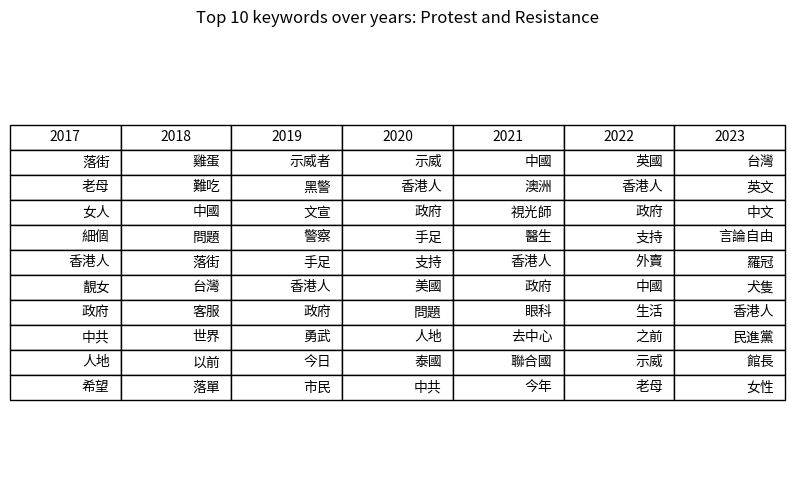

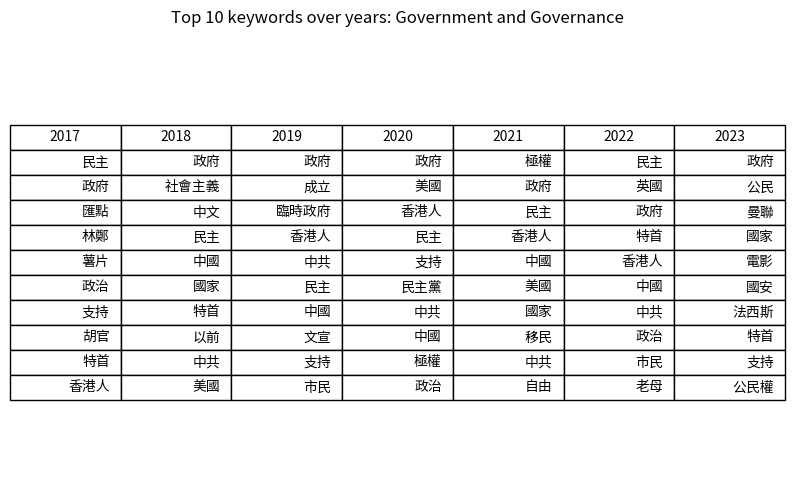

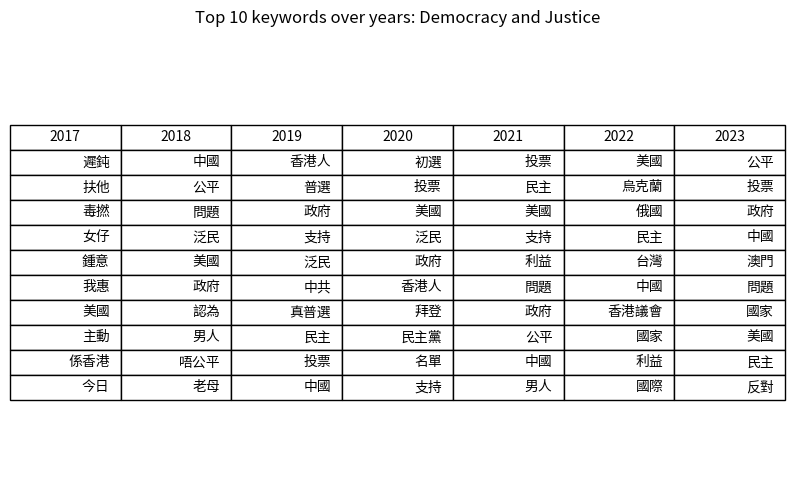

In [ ]:
word_table(PR_topwords, 'Protest and Resistance')
word_table(GG_topwords, 'Government and Governance')
word_table(DJ_topwords, 'Democracy and Justice')

### Table Translation
#### Top 10 keywords over the years: Democracy and Justice
| Rank | 2017          | 2018        | 2019              | 2020              | 2021        | 2022            | 2023        |
|------|---------------|-------------|-------------------|-------------------|-------------|-----------------|-------------|
| 1    | Slow / dull   | China       | Hong Kong people  | Primary election  | Vote        | United States   | Fair        |
| 2    |futa (Not sure the exact meaning) | Fair        | general election| Vote              | Democracy   | Ukraine         | Vote        |
| 3    |lonely boy or man; dork; nerdy boy or man who women are generally not interested in (Internet slang)| Problem     | Government        | United States     | United States| Russia         | Government  |
| 4    | Girl          | Pro-democracy camp| Support          | Pro-democracy camp     | Support     | Democracy       | China       |
| 5    | Like          | United States       | Pro-democracy camp     | Government        | Interest    | Taiwan          | Macau       |
| 6    | My benefit (Not sure the exact meaning)    | Government  | Chinese Communist Party| Hong Kong people| Problem     | China          | Problem     |
| 7    | United States | Believe     | True general election| Biden          | Government  | Hong Kong Parliament| Nation  |
| 8    | Initiative    | Man         | Democracy         | Democratic Party | Fair    | Nation          | United States|
| 9    | Is in Hong Kong| Unfair     | Vote              | list         | China       | Interest        | Democracy   |
| 10   | Today         | Mother(swear words)      | China             |  Support       | Man         | International   | Oppose      |


#### Top 10 keywords over the years: Protest and Resistance
| Rank | 2017                                          | 2018                                    | 2019                                               | 2020                 | 2021                        | 2022                | 2023                                               |
|------|-----------------------------------------------|-----------------------------------------|----------------------------------------------------|----------------------|-----------------------------|--------------------|----------------------------------------------------|
| 1    | Hit the Streets                         | **Egg (Demonstration tool/political metaphor, referring to the suppressed people)**| Protester         | Protest              | China                    | United Kingdom     | Taiwan             |
| 2    | Mother(swear words)                           | **Unpalatable(context-dependent)**          | Corrupt police / Brutal police | Hongkonger           | Australia                | Hong Kong people  | English      |
| 3    | Woman                                         | China                                   | Propaganda / Publicity material | Government        | Optometrist                     | Government     | Chinese                                  |
| 4    | Child/Kid                                     | Problem                                 | Police                          | Brothers and sisters / Comrades | Doctor        | Support       | Freedom of speech      |
| 5    | Hong Kong people                              | Hit the Streets                   | Brothers and sisters / Comrades | Support             | Hong Kong people                | Takeout / Delivery | **Nathan Law Kwun-chung**     |
| 6    | Beautiful woman                               | Taiwan                                  | Hong Kong people                    | United States       | Government             | China         | Dog    |
| 7    | Government                                    | Customer service                        | Government                      | Problem            | Ophthalmology              |Life| Hong Kong people        |
| 8    | Chinese Communist Party                       | World                                   | Valor / Brave                   |  Others / Someone else's  |Decentralize          |Before|Democratic Progressive Party      |
| 9    | Others / Someone else's                       | Before                                  | Today                           | Thailand           | United Nations          |Protest |**Holger Chen (a Taiwanese internet celebrity)**   |
| 10   | Hope                                          | Place an order / Stand alone            | Citizens                        | Chinese Communist Party | This year            |Mother(swear words)|Female                   |


#### Top 10 keywords over the years: Government and Governance
| Rank | 2017          | 2018          | 2019              | 2020      | 2021      | 2022      | 2023        |
|------|---------------|---------------|-------------------|-----------|-----------|-----------|-------------|
| 1    | Democracy     | Government    | Government        | Government| Totalitarianism| Democracy | Government  |
| 2    | Government    | Socialism     | Establishment     | United States| Government| United Kingdom| Citizens    |
| 3    | **Meeting Point (Former Hong Kong political group, the predecessor of the Hong Kong Democratic Party)**          | Chinese       | **Provisional Government (protest slogan)**| Hong Kong People| Democracy | Government| Manchester United|
| 4    | **Carrie Lam (Former Chief Executive of HK, 2017-2022)**   | Democracy     | Hong Kong People  | Democracy | Hong Kong People| Chief Executive| Nation      |
| 5    | **Potato Chips (Nickname of John Tsang Chun-wah, 2017 HK Chief Executive Candidates)**  | China         | Chinese Communist Party| Support  | China    | Hong Kong People| Movie       |
| 6    | Politics      | Nation        | Democracy         | Democratic Party| United States| China| National Security|
| 7    | Support       | Chief Executive| China       | Chinese Communist Party| Nation   | Chinese Communist Party  | Fascism     |
| 8    | **Hu Official (Nickname of Woo Kwok-hing, 2017 HK Chief Executive Candidates)**   | Before    | Propaganda           | China     | Immigration| Politics | Chief Executive|
| 9    | Chief Executive| Chinese Communist Party| Support| Totalitarianism| Chinese Communist Party| Citizen    | Support     |
| 10   | Hong Kong People| United States|   Citizens | Politics  | Freedom   |Mother(swear words)| Civil Rights |




In [47]:
def plot_word_frequency(df, x):
    """
    Plot the frequency change of topwords that appears more than x years

    Inputs:
        - df: the data source
        - x: the threshold for plotting (at least aprears in x years' topword list)

    Output: Plot graph
    """
    frequent_words = []
    
    for word, group in df.groupby(['word']):
        if len(group) >= x:
            frequent_words.append(word[0])
    
    plt.figure(figsize=(10, 6))
    for word in frequent_words:
        plt.plot(df[df['word'] == word]['year'], df[df['word'] == word]['frequency'], label=word)
    
    plt.xlabel('Year')
    plt.ylabel('Frequency')
    plt.title('Word Frequency Over Years')
    plt.legend()
    plt.show()

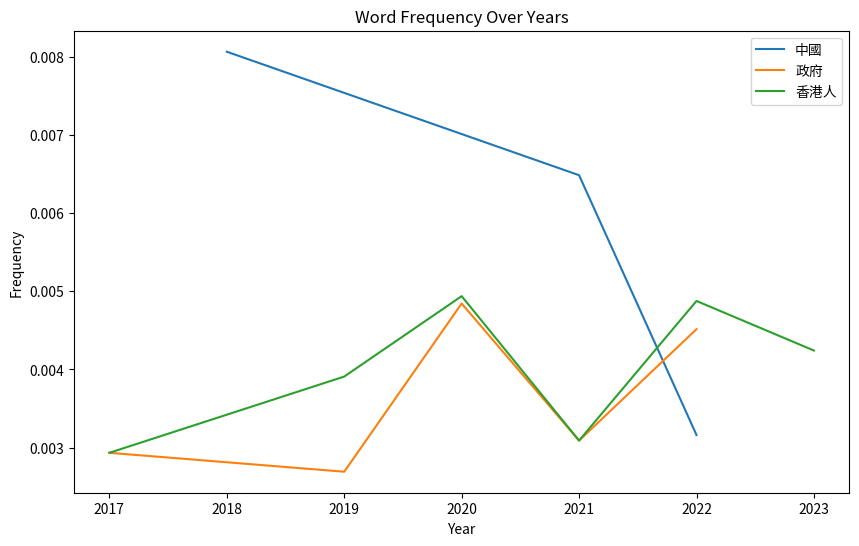

In [48]:
plot_word_frequency(PR_topwords, 3)

Translation:

China<br>
Government<br>
Hong Kong People<br>

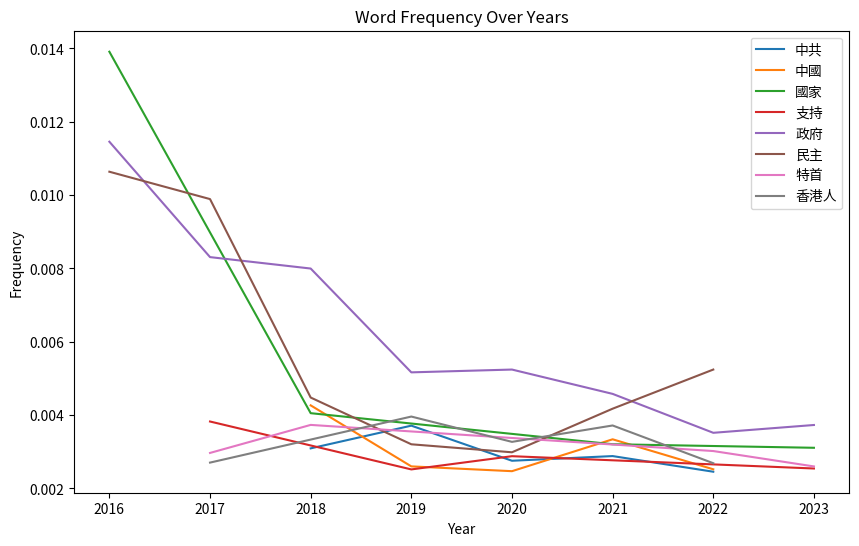

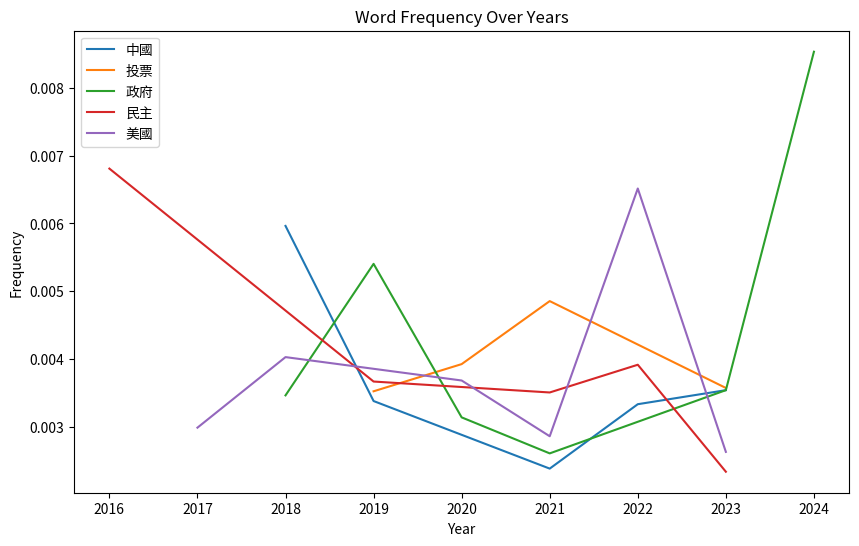

In [49]:
plot_word_frequency(GG_topwords, 4)
plot_word_frequency(DJ_topwords, 4)

#### Translation
Graph 1:

Communist Party of China<br>
China<br>
nation<br>
support<br>
government<br>
democracy<br>
chief executive<br>
Hong Kong people<br>

Graph 2:

China<br> Votes<br> Government<br> Democracy<br> America



## DTM
Here we use the LdaSeqModel for dynamic topic modeling.

In [ ]:
combined_df = pd.concat([GG_df, PR_df, DJ_df], ignore_index=True)

In [64]:
time_slice = combined_df.groupby('year').size().tolist()
time_slice

[6, 36, 36, 36, 36, 36, 36, 35, 6]

In [67]:
#dictionary
dictionary = Dictionary(combined_df['cleaned_text'])

In [68]:
# corpus
corpus = [dictionary.doc2bow(text) for text in combined_df['cleaned_text']]

In [183]:
# Then we serialize the corpus as a file and load it. This is an important step when the corpus is large.
# gensim.corpora.MmCorpus.serialize('senate.mm', corpus)
# senmm = gensim.corpora.MmCorpus('senate.mm')

In [70]:
#model
ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=time_slice, num_topics=3) #1. run time 2. num_topic(have 3 here since we have three topic) and explination

c:\Users\Annii\anaconda3\Lib\site-packages\gensim\models\ldaseqmodel.py:298: RuntimeWarning: divide by zero encountered in scalar divide
  convergence = np.fabs((bound - old_bound) / old_bound)


In [ ]:
ldaseq.print_topics(time=0)[2]

In [ ]:
ldaseq.print_topic_times(topic=2)

In [72]:
def plot_word_changes(data, min_occurrences):
    """
    Plot most related words by the probability

    Inputs:
        - data: the data source
        - min_occurrences: (int) the minimum number of year that one keyword has
                            top probability
    
    Output: plot
    """
    plt.figure(figsize=(10, 6))  

    words_count = {}  

    for sublist in data:
        for item in sublist[:10]:
            word = item[0]
            words_count[word] = words_count.get(word, 0) + 1

    for word, count in words_count.items():
        if count >= min_occurrences:
            x = []  
            y = []  
            for sublist in data:
                for item in sublist:
                    if item[0] == word: 
                        x.append(2016 + data.index(sublist))  
                        y.append(item[1] * 100) 
            plt.plot(x, y, label=word) 
    plt.xlabel('Time')  
    plt.ylabel('Value') 
    plt.title('Word Changes Over Time')  
    plt.legend() 
    plt.grid(True)  
    plt.show()  
# frequency change little

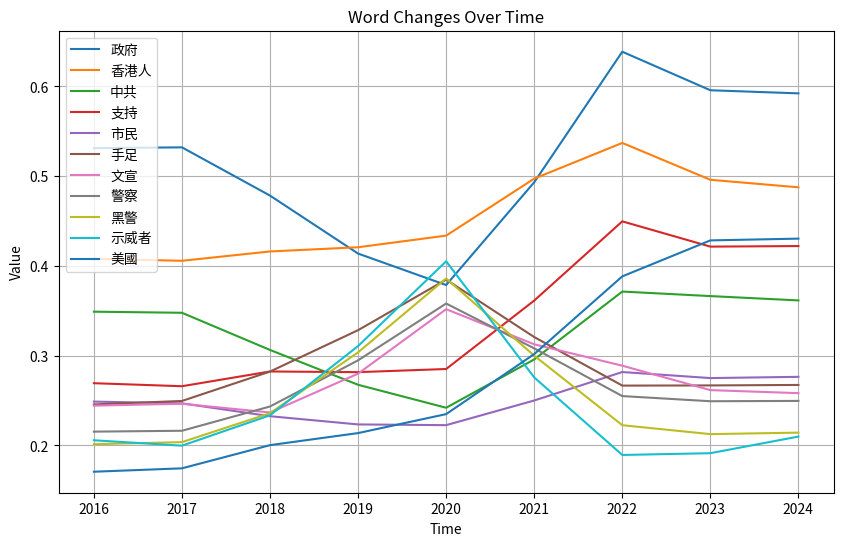

In [73]:
plot_word_changes(ldaseq.print_topic_times(topic=2), 4)

#### Translation

government<br>
Hong Kong people<br>
Communist Party of China<br>
support<br>
citizen<br>
siblings<br>
Propaganda<br>
police<br>
Black police<br>
Demonstrator<br>
USA<br>

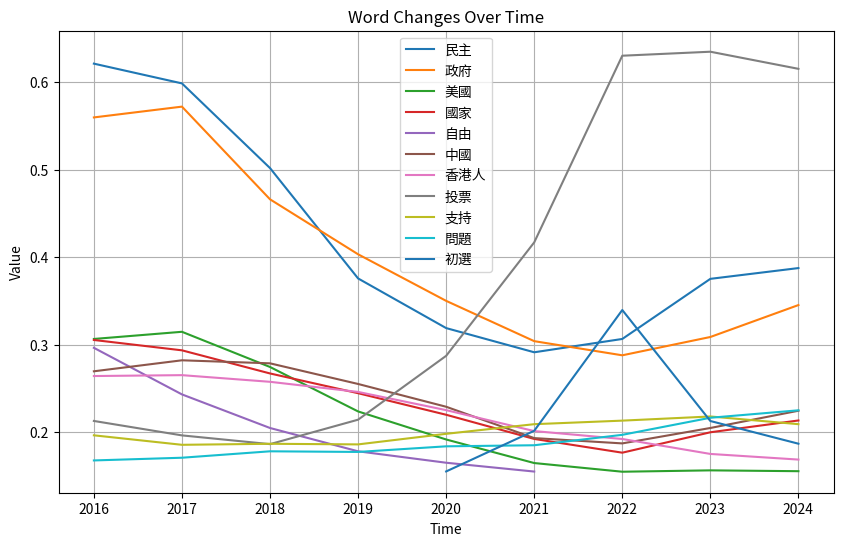

In [75]:
plot_word_changes(ldaseq.print_topic_times(topic=0), 4)

#### Translation
Pro-democracy camp<br>
Democratic Party<br>
Communist Party of China<br>
support<br>
China<br>
USA<br>
government<br>
Hong Kong people<br>
election<br>
question<br>

In [78]:
pyLDAvis.save_html(vis_wrapper, 'DTM.html')

In [ ]:
#visualization in pyldavis
# from gensim.models.wrappers.dtmmodel import DtmModel
# from gensim.corpora import Dictionary, bleicorpus
# import pyLDAvis

# dtm_path = "/Users/bhargavvader/Downloads/dtm_release/dtm/main"
# dtm_model = DtmModel(dtm_path, corpus, time_slice, num_topics=5, id2word=dictionary, initialize_lda=True)
# dtm_model.save('dtm_news')

# if we've saved before simply load the model
#dtm_model = DtmModel.load('dtm_news')

In [ ]:
# ldaseq.save('dtm_test')
#dtm_model = DtmModel.load('dtm_test')

In [ ]:
# experiment part, not used for final presentation/report

wordcloud

In [104]:
custom_font_path = r'C:\Users\Annii\Documents\HL\Study\UChicago\24 Winter\122\msyh.ttc'
#custom_font = FontProperties(fname=custom_font_path)


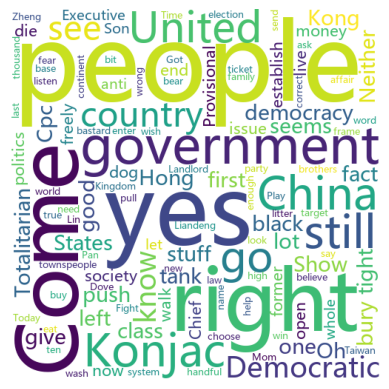

In [157]:
wc = wordcloud.WordCloud(font_path=custom_font_path, background_color="white", max_words=150, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(GG_translate))
plt.imshow(wc)
plt.axis("off")
plt.savefig("Government and Governance_E.png", format = 'png')

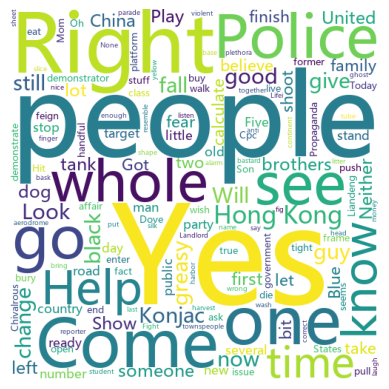

In [152]:
wc = wordcloud.WordCloud(font_path=custom_font_path, background_color="white", max_words=150, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(PR_translate))
plt.imshow(wc)
plt.axis("off")
plt.savefig("Protest and Resistance_E.png", format = 'png')

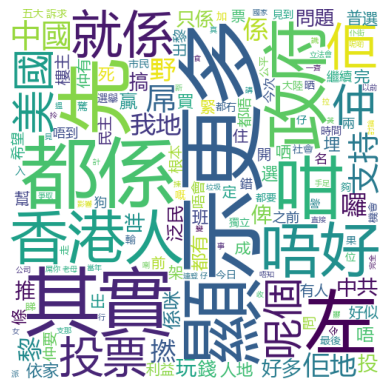

In [165]:
wc = wordcloud.WordCloud(font_path=custom_font_path, background_color="white", max_words=150, width= 1000, height = 1000, mode ='RGBA', scale=.5).generate(' '.join(DJ_cleanword))
plt.imshow(wc)
plt.axis("off")
plt.savefig("Democracy and Justice_C.png", format = 'png')